In [231]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import TensorDataset, DataLoader

from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt

In [232]:
chunksize = 10000
reader = pd.read_csv(
    "/data/hmn_data/alibaba_cluster_data/MSRTQps_sort.csv", chunksize=chunksize)


In [233]:
df = pd.DataFrame()
for index, chunk in enumerate(reader):
        if index > 10:
            break
        df = pd.concat([df, chunk])


In [234]:
# 定义步长 K
TIME_STEP = 10


def split_array_by_step(arr, k):
    return [arr[i:i+k] for i in range(0, len(arr)-k, k)]

# 按照 msinstanceid 列分组
grouped_df = df.groupby('msinstanceid')["HTTP_RT"].apply(
    lambda x: split_array_by_step(x, TIME_STEP+1)).reset_index()


In [235]:
combined_df = pd.DataFrame()

# 对于每个分组
for index, row in grouped_df.iterrows():
    if len(row["HTTP_RT"]) > 0:
        combined_df = pd.concat([combined_df, pd.DataFrame(
            np.stack([arr for arr in row["HTTP_RT"]], axis=0))])

In [255]:
scaler = MinMaxScaler()
workload = scaler.fit_transform(combined_df)

In [256]:
# 将数据转换为LSTM模型的输入形式
def create_sequences(data, time_steps=1):
    xs, ys = [], []
    for i in range(len(data)):
        xs.append(data[i][:time_steps])
        ys.append(data[i][time_steps])
    return np.array(xs), np.array(ys)

x_train, y_train = create_sequences(workload, TIME_STEP)

In [257]:
x_train=np.expand_dims(x_train, axis=2)
y_train=np.expand_dims(y_train, axis=1)

print(x_train.shape)
print(y_train.shape)

(9907, 10, 1)
(9907, 1)


In [258]:
train_size = int(len(x_train) * 0.8)
val_size = len(x_train) - train_size

x_train, x_val = x_train[0:train_size, :,
                         :], x_train[train_size:, :, :]
y_train, y_val = y_train[0:train_size], y_train[train_size:]


In [259]:
INPUT_DIM = 1
output_dim = 1
batch_size = 10  #每轮训练模型时，样本的数量
epochs = 20      #训练50轮次
hidden_size = 64
num_layers = 4

In [260]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim=1):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(
            input_dim, hidden_dim, num_layers=num_layers, batch_first=True, bidirectional=False)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])

        return out


In [261]:
def train_model(train_x, train_y, model, epochs, batch_size, device):
    train_x = torch.tensor(train_x, dtype=torch.float32).to(device)
    train_y = torch.tensor(train_y, dtype=torch.float32).to(device)
    dataset = TensorDataset(train_x, train_y)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters())

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        total_samples = 0

        for batch_x, batch_y in dataloader:
            optimizer.zero_grad()
            output = model(batch_x)
            loss = criterion(output, batch_y)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * batch_x.size(0)
            total_samples += batch_x.size(0)

        epoch_loss = running_loss / total_samples
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss:.4f}")

    return model


In [262]:
def predict(model, predict_x, device):
    predict_x = torch.tensor(predict_x, dtype=torch.float32).to(device)
    model.eval()
    with torch.no_grad():
        y_pred = model(predict_x)
    return y_pred.cpu().numpy()


In [263]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = LSTMModel(INPUT_DIM, hidden_size, num_layers, output_dim)
model.to(device)

trained_model = train_model(x_train, y_train, model,
                            epochs, batch_size, device)


Epoch 1/20, Loss: 0.0005
Epoch 2/20, Loss: 0.0002
Epoch 3/20, Loss: 0.0002
Epoch 4/20, Loss: 0.0002
Epoch 5/20, Loss: 0.0002
Epoch 6/20, Loss: 0.0002
Epoch 7/20, Loss: 0.0002
Epoch 8/20, Loss: 0.0002
Epoch 9/20, Loss: 0.0001
Epoch 10/20, Loss: 0.0001
Epoch 11/20, Loss: 0.0003
Epoch 12/20, Loss: 0.0002
Epoch 13/20, Loss: 0.0001
Epoch 14/20, Loss: 0.0005
Epoch 15/20, Loss: 0.0001
Epoch 16/20, Loss: 0.0001
Epoch 17/20, Loss: 0.0001
Epoch 18/20, Loss: 0.0001
Epoch 19/20, Loss: 0.0001
Epoch 20/20, Loss: 0.0001


In [266]:
y_pred = predict(trained_model, x_val, device)

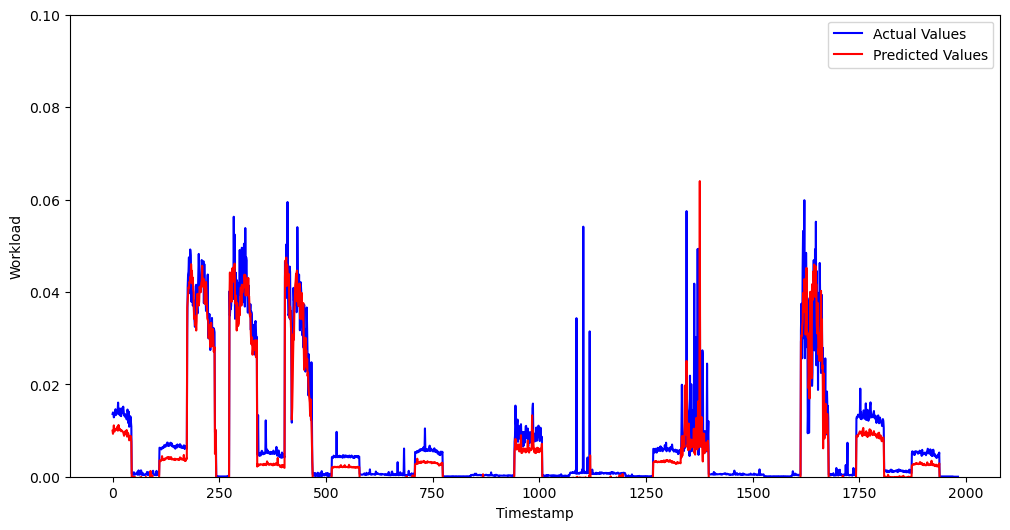

In [271]:
def plot_predictions(y_val, y_pred):
    plt.figure(figsize=(12, 6))
    plt.ylim(0, 0.1)
    plt.plot(y_val, label="Actual Values", color='blue')
    plt.plot(y_pred, label="Predicted Values", color='red')
    plt.xlabel("Timestamp")
    plt.ylabel("Workload")
    plt.legend()
    plt.show()

plot_predictions(y_val, y_pred)
# 保存模型
torch.save(model.state_dict(), "../../model/LSTM.pt")